## Installing needed libraries

In [3]:
pip install optuna lightgbm mlflow xgboost

Note: you may need to restart the kernel to use updated packages.


## EDA

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import numpy as np
import mlflow
import os

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('fin_no_leakage - Sheet1.csv')
df

,Credit ID,Customer ID,Loan Created Date,hist_notes,overdues_sum,overdues_max,overdues_mean,n_loan_types,last_end,Type Credit,Sex,Birthday
0,695553,843,2021-05-20,2,64.0,32.0,32.000000,1,2019-03-07,Normal,Man,1960-09-25
1,992484,1801,2021-07-02,1,32.0,32.0,32.000000,1,2019-09-03,Normal,Woman,1982-12-24
2,602834,694,2021-04-21,4,0.0,0.0,0.000000,2,2019-10-03,Normal,Woman,1952-12-07
3,272034,1755,2021-08-09,1,0.0,0.0,0.000000,1,2019-11-02,Normal,Man,1995-04-24
4,601804,318,2020-09-27,4,21.0,21.0,5.250000,2,2019-10-03,Normal,Woman,1960-03-14
...,...,...,...,...,...,...,...,...,...,...,...,...
567,368316,857,2021-10-15,6,79.0,79.0,13.166667,3,2019-12-02,Normal,Man,1993-01-22
568,797427,371,2022-03-06,3,50.0,24.0,16.666667,2,2021-08-24,Problem,Woman,1949-04-12
569,490044,1207,2020-03-30,0,NaN,NaN,NaN,0,NaN,Problem,Man,1955-08-29
570,698771,1357,2022-10-29,1,0.0,0.0,0.000000,1,2019-04-06,Normal,Woman,1991-06-01


In [6]:
df.isnull().sum()

Credit ID             0
Customer ID           0
Loan Created Date     0
hist_notes            0
overdues_sum          1
overdues_max          1
overdues_mean         1
n_loan_types          0
last_end              1
Type Credit           0
Sex                   0
Birthday             25
dtype: int64

In [7]:
df['last_end'].isnull()

0      False
1      False
2      False
3      False
4      False
       ...  
567    False
568    False
569     True
570    False
571    False
Name: last_end, Length: 572, dtype: bool

In [8]:
df = df.drop(569)  # dropping the problematic row

In [9]:
df['n_loan_types'].unique()

array([1, 2, 3])

In [10]:
# Смотрим нет ли дубликатов после объединения
double = df[df.duplicated(subset=["Customer ID", "Credit ID"])]
double

,Credit ID,Customer ID,Loan Created Date,hist_notes,overdues_sum,overdues_max,overdues_mean,n_loan_types,last_end,Type Credit,Sex,Birthday
56,76655,229,2021-07-11,2,0.0,0.0,0.0,2,2019-12-02,Problem,Man,1962-11-16
57,76655,1966,2020-01-06,1,13.0,13.0,13.0,1,2019-07-05,Problem,Man,1990-08-23
282,651171,49,2021-02-10,2,0.0,0.0,0.0,1,2019-08-04,Normal,Man,1978-05-03
283,651171,1738,2021-09-19,2,72.0,72.0,36.0,2,2019-11-02,Normal,Man,1956-03-25


In [11]:
df.isnull().sum() 

Credit ID             0
Customer ID           0
Loan Created Date     0
hist_notes            0
overdues_sum          0
overdues_max          0
overdues_mean         0
n_loan_types          0
last_end              0
Type Credit           0
Sex                   0
Birthday             25
dtype: int64

In [12]:
df["Birthday"] = pd.to_datetime(df["Birthday"], errors="coerce") 
df["loan_date"] = pd.to_datetime(df["Loan Created Date"], dayfirst=True) 
df["loan_end"] = pd.to_datetime(df["last_end"], errors="coerce", dayfirst=True) 
df["Age"] = (df["loan_date"] - df["Birthday"]).dt.days // 365 #! дату рождения следовало вычитать из даты заявки или другой исторической даты имеющей какое-то значение на момент заявки (today сейчас сильно отличается от today на момент формирования заявки)

df['loan_days']= (df['loan_end']-df['loan_date']).dt.days

df["loan_year"] = df["loan_date"].dt.year 
df["loan_months"] = df["loan_date"].dt.month

df["gender"] = df["Sex"].map({"Woman": 1, "Man": 0}).astype('float64') 
df['TARGET'] = df['Type Credit'].map({'Problem':1, 'Normal':0}).astype('float64')

In [17]:
# Сохранила колонки, чтобы не терять данные. Подставила медиану вместо Nan.
brth_median = df['Birthday'].median()
df['Birthday']=df['Birthday'].fillna(brth_median)

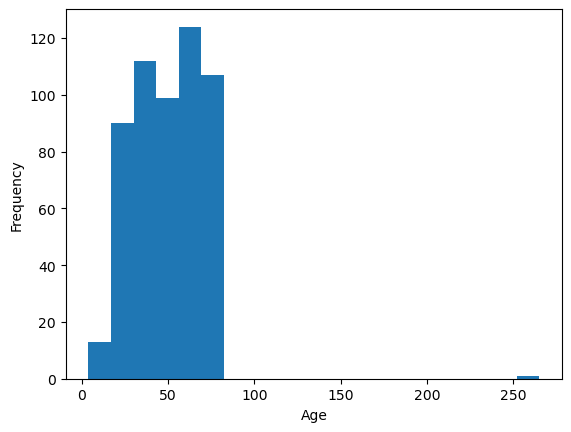

In [18]:
df['Age'].plot(kind='hist', bins=20)
plt.xlabel('Age')
#plt.xlim(50,150)
plt.show()

In [19]:
count_outlier = df[df['Age']<5].shape[0]
count_outliers = df[df['Age']>100].shape[0]
print(f'Extremely young customers: {count_outlier}, impossibly old customers: {count_outliers}')

Extremely young customers: 1, impossibly old customers: 1


In [21]:
# df w/o Age outliers
df = df[(df['Age']>=5)  & (df['Age'] <100)]
df.isnull().sum()

Credit ID             0
Customer ID           0
Loan Created Date     0
hist_notes            0
overdues_sum          0
overdues_max          0
overdues_mean         0
n_loan_types          0
last_end              0
Type Credit           0
Sex                   0
Birthday              0
loan_date             0
loan_end             42
Age                   0
loan_days            42
loan_year             0
loan_months           0
gender                0
TARGET                0
dtype: int64

In [22]:
df['Age'].astype(int)

0      60
1      38
2      68
3      26
4      60
       ..
566    29
567    28
568    72
570    31
571    67
Name: Age, Length: 544, dtype: int64

In [23]:
count300 = (df['loan_days']==300).shape[0]
count300

544

In [24]:
numerical_cols = ['hist_notes', 'overdues_sum', 'overdues_max', 'overdues_mean', 'n_loan_types	', 'Age', 'loan_year', 'loan_months', 'TARGET', 'gender']

In [25]:
numerical_df = df.select_dtypes(include="number").copy()
numerical_df

,Credit ID,Customer ID,hist_notes,overdues_sum,overdues_max,overdues_mean,n_loan_types,Age,loan_days,loan_year,loan_months,gender,TARGET
0,695553,843,2,64.0,32.0,32.000000,1,60.0,-687.0,2021,5,0.0,0.0
1,992484,1801,1,32.0,32.0,32.000000,1,38.0,-846.0,2021,7,1.0,0.0
2,602834,694,4,0.0,0.0,0.000000,2,68.0,-773.0,2021,4,1.0,0.0
3,272034,1755,1,0.0,0.0,0.000000,1,26.0,-910.0,2021,8,0.0,0.0
4,601804,318,4,21.0,21.0,5.250000,2,60.0,-567.0,2020,9,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,749742,1510,3,0.0,0.0,0.000000,2,29.0,-906.0,2021,8,0.0,0.0
567,368316,857,6,79.0,79.0,13.166667,3,28.0,-976.0,2021,10,0.0,0.0
568,797427,371,3,50.0,24.0,16.666667,2,72.0,NaN,2022,3,1.0,1.0
570,698771,1357,1,0.0,0.0,0.000000,1,31.0,-1243.0,2022,10,1.0,0.0


<Axes: ylabel='count'>

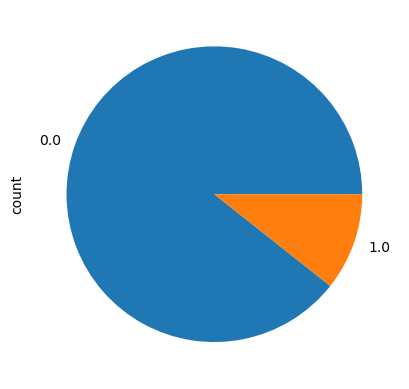

In [26]:
df['TARGET'].value_counts().plot(kind='pie')
# Imbalanced dataset

## Finding the most prominent features by correlation matrix and Sequential Feature Selector

<Axes: >

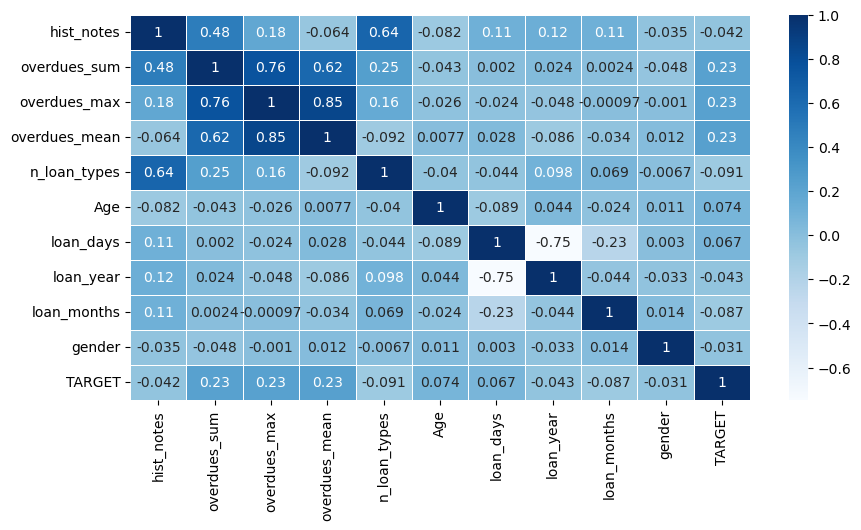

In [27]:
# Correlation matrix
correlation_matrix = numerical_df.drop(['Credit ID', 'Customer ID'],axis=1).corr()
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=0.5)

Target correltes the best with overdues family

In [28]:
#SFS для выявления наиболее оптимальных features
SFS = SequentialFeatureSelector(estimator=LogisticRegression(), n_features_to_select=8, direction='backward')

In [29]:
X1=numerical_df.drop(['Credit ID','Customer ID','TARGET', 'loan_days'],  axis=1)
y1= numerical_df['TARGET']

In [30]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=101)

In [31]:
X_train1.isnull().sum()

hist_notes       0
overdues_sum     0
overdues_max     0
overdues_mean    0
n_loan_types     0
Age              0
loan_year        0
loan_months      0
gender           0
dtype: int64

In [32]:
SFS.fit(X_train1, y_train1)

SequentialFeatureSelector(direction='backward', estimator=LogisticRegression(),
                          n_features_to_select=8)

In [33]:
sfs_features = X_train1.columns[SFS.get_support()].tolist()

In [34]:
sfs_features

['hist_notes',
 'overdues_max',
 'overdues_mean',
 'n_loan_types',
 'Age',
 'loan_year',
 'loan_months',
 'gender']

In [37]:
# Top features from correlation

In [38]:
numerical_df.corr(numeric_only=True)['TARGET'].sort_values(ascending=False)

TARGET           1.000000
overdues_mean    0.230006
overdues_max     0.227595
overdues_sum     0.226817
Age              0.073834
loan_days        0.066805
Credit ID        0.026804
gender          -0.030660
hist_notes      -0.042244
loan_year       -0.042612
Customer ID     -0.049838
loan_months     -0.087034
n_loan_types    -0.091224
Name: TARGET, dtype: float64

## Hyperparameters tuning and balancing classes using SMOTE

In [39]:
selected_features = ['overdues_max','overdues_mean', 'overdues_sum',
 'n_loan_types', 'Age', 'gender', 'loan_year', 'loan_months']

In [40]:
X = numerical_df[selected_features]
y = numerical_df['TARGET']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=101)

In [42]:
# Dealing with imbalance

In [43]:
smote = SMOTE(random_state=101)

In [44]:
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [45]:
# Objective functions for HP tuning by OPTUNA

In [71]:
def objective(trial):
    params = {
       "n_estimators": trial.suggest_int("lgb_n_estimators", 500, 3000, step=250),
        "learning_rate": trial.suggest_float("lgb_lr", 0.005, 0.2, log=True),
        "num_leaves": trial.suggest_int("lgb_num_leaves", 30, 255),
        "max_depth":trial.suggest_int("lgb_max_depth", -1, 25),
        "min_child_samples": trial.suggest_int("lgb_min_child_samples", 10, 200),
        "subsample": trial.suggest_float("lgb_subsample", 0.5, 1.0),
        "objective": "binary",
        "n_jobs": -1,
        "objective": "binary",
        "verbose": -1,}
    lgbc = LGBMClassifier(**params)
    lgbc.fit(X_train_bal, y_train_bal)
    val_preds = lgbc.predict_proba(X_test)[:, 1]
    auc_sc = roc_auc_score(y_test, val_preds)
    return auc_sc

Training Optuna

In [355]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best accuracy:", study.best_trial.value)

[I 2025-08-23 22:45:50,148] A new study created in memory with name: no-name-6ae8297a-693d-4868-ba62-a86c9c0e110d
[I 2025-08-23 22:45:52,970] Trial 0 finished with value: 0.7029774872912128 and parameters: {'lgb_n_estimators': 2500, 'lgb_lr': 0.009295171721223593, 'lgb_num_leaves': 103, 'lgb_max_depth': 19, 'lgb_min_child_samples': 99, 'lgb_subsample': 0.8920142892465397}. Best is trial 0 with value: 0.7029774872912128.
[I 2025-08-23 22:45:53,528] Trial 1 finished with value: 0.6895424836601307 and parameters: {'lgb_n_estimators': 750, 'lgb_lr': 0.17303887475743213, 'lgb_num_leaves': 79, 'lgb_max_depth': 18, 'lgb_min_child_samples': 145, 'lgb_subsample': 0.6183021530890825}. Best is trial 0 with value: 0.7029774872912128.
[I 2025-08-23 22:45:57,588] Trial 2 finished with value: 0.6706608569353667 and parameters: {'lgb_n_estimators': 750, 'lgb_lr': 0.008119916055867898, 'lgb_num_leaves': 135, 'lgb_max_depth': 15, 'lgb_min_child_samples': 18, 'lgb_subsample': 0.9654084114307134}. Best is

Number of finished trials: 100
Best trial: {'lgb_n_estimators': 500, 'lgb_lr': 0.1987767475519095, 'lgb_num_leaves': 173, 'lgb_max_depth': 1, 'lgb_min_child_samples': 57, 'lgb_subsample': 0.8132071180864728}
Best accuracy: 0.7645243282498184


## Checking model with the best HPs on ROC-AUC, Optuna

In [364]:
best_params = study.best_params.copy()
best_params.update(dict(objective="binary", n_jobs=-1, random_state=101, verbose=-1))
best_lgbmc = LGBMClassifier(**best_params)

In [365]:
best_lgbmc.fit(X_train, y_train)

LGBMClassifier(lgb_lr=0.1987767475519095, lgb_max_depth=1,
               lgb_min_child_samples=57, lgb_n_estimators=500,
               lgb_num_leaves=173, lgb_subsample=0.8132071180864728, n_jobs=-1,
               objective='binary', random_state=101, verbose=-1)

ROC-AUC, Gini index results

In [366]:
probability = best_lgbmc.predict_proba(X_test)[:, 1]      # or X_te from the snippet above
auc = roc_auc_score(y_test, probability)          # or y_te
gini  = 2*auc - 1
print(f"ROC-AUC: {auc.round(2)} и Gini: {gini.round(2)}")

ROC-AUC: 0.78 и Gini: 0.55


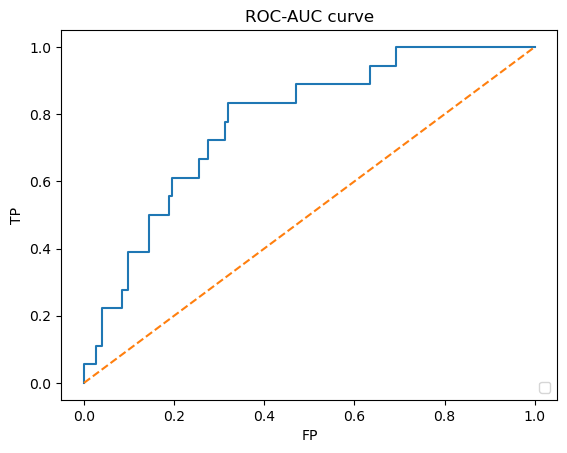

In [368]:
# 1) Get probabilities for the positive class
probabilities = best_lgbmc.predict_proba(X_test)[:, 1]   # LightGBM/XGBoost/RandomForest

# 2) Compute ROC points + AUC
FP, TP, thres = roc_curve(y_test, probabilities)
AUC_LINE = roc_auc_score(y_test, probabilities)
gini = 2*AUC_LINE - 1

# 3) Plot
plt.figure()
plt.plot(FP, TP)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('ROC-AUC curve')
plt.legend(loc='lower right')
plt.show()

## MLflow integration

In [68]:
os.environ['USER']= 'Nurperi'

In [61]:
models = [
    (
        "Logistic Regression", 
        LogisticRegression(C=1, solver='liblinear'), 
        (X_train_bal, y_train_bal),
        (X_test, y_test)
    ),
    (
        "Random Forest", 
        RFC(n_estimators=30, max_depth=3), 
        (X_train_bal, y_train_bal),
        (X_test, y_test)
    ),
    (
        "LGBMClassifier",
        LGBMClassifier(use_label_encoder=False, verbosity=-1), 
        (X_train_bal, y_train_bal),
        (X_test, y_test)
    )
]

In [79]:
mlflow.set_experiment('Credit scoring')
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.sklearn.autolog(log_input_examples=False, log_model_signatures=False)

for i, elem in enumerate(models):
    model_name = elem[0]
    model = elem[1]  
    with mlflow.start_run(run_name=model_name):
        model.fit(X_train_bal, y_train_bal)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]
    
        roc = roc_auc_score(y_test, y_proba)
        gini = 2*roc - 1

        mlflow.log_param
        
        mlflow.log_metric('ROC-AUC', roc)
        mlflow.log_metric('Gini Index', gini)
        

2025/08/24 16:32:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression at: http://localhost:5000/#/experiments/946423413565731445/runs/1293512ae54b4561952107e791cc7fbb
🧪 View experiment at: http://localhost:5000/#/experiments/946423413565731445


2025/08/24 16:32:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://localhost:5000/#/experiments/946423413565731445/runs/e769791eae3b4787b8bfcb813f90d40f
🧪 View experiment at: http://localhost:5000/#/experiments/946423413565731445
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Info] Number of positive: 339, number of negative: 339
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 678, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

In [ ]:
# Experiment to tune HPs
params2 = {
    'n_estimators': [500, 3000],
    'learning_rate': [0.005, 0.02],
    'num_leaves': [30, 255]   
}

with mlflow.start_run(run_name="LightGBM Tuned"):
    lgbm_tuned = RandomizedSearchCV(
        estimator=LGBMClassifier(random_state=101, verbosity=-1),
        param_distributions=params2,
        scoring="roc_auc", 
        cv=5,
        n_jobs=-1,
        n_iter=10
    )
    lgbm_tuned.fit(X_train, y_train)
    # metrics
    y_proba1 = lgbm_tuned.best_estimator_.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_proba1)
    mlflow.log_metric("roc_auc", auc)
    mlflow.log_metric("gini", (2*auc - 1))